## AAI30001 Small Project
#### **Group: SP_8**
 - Chua Chen Yi (2302822)
 - Wong Jun Jai (2302765)

## Methodology

#### Our proposed method of improving accuracy over the baseline score is as follows:
### 1. Identify a pre-trained model to be our baseline for fine-tuning
- Before starting our search, we manually re-created the same testing environment as the sample code. This included splitting the dataset into training, validation and testing identically to the sample. In addition, the use of the TestUA for determining overall performance was use
    - *Minor note: We have noticed the way the dataset is split for testing is not the same as how it is described in the text. For example, the test set should only contain files from 'Ses01F' and only from the female speaker. However, checking the dataset class showed that this is not true.*
- With a simple evaluation pipeline in placee, we randomly choose 10 different models publically availble from hugging face, and proceeded to score them. They scored a range from 0.60-0.80 on the test dataset.
- We decided to use the same base model: **"facebook/wav2vec2-base"** with the goal of fine tuning according to the rules and achieve at least 0.70
### 2. Perform Data Augmentation On Dataset
- #### Augmentation 1
    - Details
- #### Augmentation 2
    - Details
### 3. Identify Strengths & Weakness of Pre-Trained Model
- We started by training the model for a few epochs to get a general idea of how it performs. A sample confusion matrix is shown here:

             A   H    N   S
        A  103   8   35   1
        H    8  79   36   9
        N    2   7  109  53 <- Highest Error
        S    1   8   10  59
        
    In general, the model is able to differentiate angry and happy emotions with a high degree of accuracy. However, the model is not good at differentiaing between neutral and sad emotions. Its greatest weakness is predicting a neutral emotion as a sad one
                
### 4. Use Secondary Model With Text Embeddings
- We have decided not to use extracted text embeddings as a feature of our first model, but instead have a completely seperate model extract and perform sentiment analysis on the text. The final prediction will be a combination of both models.
    - This method allows us to:
        1. Manage our time better as work can be done to improve the performance of both indepenently.
        2. Change our base model if we find a better one.
        3. Choose more sophisticated speech-to-text and sentiment analysis models
### 5. Develop Algorithm To Merge Predictions
- Our final implementation consist of getting the confidence for each label using softmax in addition to its original prediction. The predictions for the 2nd model is then merged into a single CSV file. A gridsearch-like function will identify the optimal parameters *(highlighted in **Bold**)*.
- All models tested have improved scores. In general, models with <0.65 score will see a boost of 2-4%, while models >0.65 score will gain 0-2%. We have also tried training a binary classifier for just sad and not sad, however most of the time the accuracy actually decreased.
    ### Merge Algorithm
    - The algorithm that determines the final predictions is a combination of 3 different strategies:
        1. **Merging Strategy:** When to rely on the 2nd model?
        2. **Prediction Strategy:** How to rely on the 2nd model?
        3. **Mapping Strategy:** How to map sentiment to emotions?
    ### 5A. Merging Strategy
    We have identified 2 possible metrics to decide when to rely on the 2nd model
    - **Entrophy Threshold**
    We apply a calculate the entrophy based on the 4 confidence scores, following the logic that a lower overall entrophy will mean the model is most confident in its prediction. We will refer to the 2nd model when the entrophy is above the ***entrophy_threshold***.
    - **Argmax Threshold**
    We apply a simple argmax on the 4 confidence scores. If the value is below the ***argmax_threshold***, we will refer to the 2nd model for the final prediction
    ### 5B. Prediction Strategy
    We have identified 3 possible metrics to decide how to rely on the 2nd model
    - **Default**
    Prefer prediction of 2nd model in all situations
    - **Ignore**
    We identified the original model is very good at angry and happy emotions. So we always prefer the orignal model's predictions if it detects angry or happy
    - **Ignore When Match**
    If both models agree on the same prediction, we ignore however low the confidence is and assume is correct
    ### 5C. Mapping Strategy
    Because our sentiment analysis outputs 3 classes, while we have 4 emotions, we ill need to map 1 class to 2 emotions. This corresponds to the 'Negative' sentiment being mapped to either 'Angry' or 'Sad'. We have implemented the following methods:
    - **Simple Mapping**
    We decide on a ***sentiment_threshold*** value, where anything above is 'Sad'. This can also ***fliped*** around, ie. anything above is 'Angry' as there is no defined way to map the negative sentiment
    - **Reference Mapping**
    When a negative sentiment needs to be mapped, the confidence of 'Sad' and 'Angry' from the original model is looked up, and Argmax is used to return the most likely emotion.
    
    
    
    
    


## All Notebook Settings & Parameters
***Everything that can be set and changed will be in here***

### Settings & Flags

In [1]:
# For Colab/Kaggle Notebook.
CLOUD = False

DEFAULT_MODE = True # Runs everything with default settings

# Model Training --------------------------------
LOAD_PREVIOUSLY_TRAINED_MODEL = False # If false, skips training a fresh model and load a previously trianed one
PREVIOUSLY_TRAINED_MODEL_PATH = r'C:\Users\ChenYi\Downloads\AAI3001_Project\TransferLearning\models\wav2vec2-large-e5'

SKIP_TESTING_AFTER_TRAINING = True # Does not run any test after training. Used when you want to skip directly to multi-model
ONLY_RUN_TRAINING_LOOP = False # True stops the notebook once Test UA is computed
SKIP_TRAINING = True          # Disable trainer.train() command
JUST_PRINT_TEST_UA = False     # Prints only the score. False prints out all other metrics
PLOT_TRAINING_GRAPHS = True    # Prints out train and val loss charts

# Model Loading & Output -----------------------------------
PRE_TRAINED_MODEL_NAME = "facebook/wav2vec2-base"
SPEECH_TO_TEXT_MODEL_NAME = "facebook/wav2vec2-base-960h"
SENTIMENT_MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

OUTPUT_MODEL_NAME = "integrated-notebook-finaltest-default-model"
TRAINING_OUTPUT_FOLDER = "./Training-Output"
PREDICTION_OUTPUT_FOLDER = "./Predictions"

# Output Selection --------------------------------
SAVE_FINAL_PREDICTION_CSV = True
FORMAT_CSV_FOR_KAGGLE = True # Entire notebook must run before a properly formatted label.csv can be generated!

# If you have skipped training a new model, you can also directly use kaggle formatted label.csv to generate the Test UA score. If set true
# will not load any model at all. Does not allow you to continue notebook as the required softmax values are not available
LOAD_PREDICTION_DIRECTLY_FROM_CSV = False
PREDICTION_CSV_FILEPATH = r'C:\Users\ChenYi\Downloads\AAI3001_Project\labels\model-4-original.csv'

# Mutli Model Parameter Search Selection  ------------------------------------
RUN_PARAMETER_SEARCH = True
LOAD_MULTI_PREDICTION_DIRECTLY_FROM_CSV = False # Automatically skips running mutli model prediction as well
MULTI_PREDICTION_CSV_FILEPATH = ''

# For debug
FORCE_MULTI_PREDICT = False # Manually run multi predict to generate raw prediction csv
FORCE_PARAMETER_SEARCH = False # Manually run Paramter searching

In [2]:
# Ensures conflicting flags are set properly and hopefully dones't crash
if LOAD_PREDICTION_DIRECTLY_FROM_CSV:
    LOAD_PREVIOUSLY_TRAINED_MODEL = False
    ONLY_RUN_TRAINING_LOOP = True
    
if FORCE_MULTI_PREDICT:
    SKIP_TESTING_AFTER_TRAINING = True
    SKIP_TRAINING = True
    ONLY_RUN_TRAINING_LOOP = False
    LOAD_MULTI_PREDICTION_DIRECTLY_FROM_CSV = False
    
if DEFAULT_MODE:
    LOAD_PREVIOUSLY_TRAINED_MODEL = False
    SKIP_TESTING_AFTER_TRAINING = False
    ONLY_RUN_TRAINING_LOOP = False
    SKIP_TRAINING = False
    SAVE_FINAL_PREDICTION_CSV = True
    FORMAT_CSV_FOR_KAGGLE = True
    LOAD_PREDICTION_DIRECTLY_FROM_CSV = False
    RUN_PARAMETER_SEARCH = True
    LOAD_MULTI_PREDICTION_DIRECTLY_FROM_CSV = False

### Example Setting Presets

#### These are tested default settings that should hopefully not crash. :D
- ##### Default: Fine-tune pre-trained model on IEMOCAP. Run test to verify model is working fine, then merge predictions from multi-model after searching all possible parameters. Prints (and/or saves) the highest Test UA score possible with this model:

        LOAD_PREVIOUSLY_TRAINED_MODEL = False 
        SKIP_TESTING_AFTER_TRAINING = False
        ONLY_RUN_TRAINING_LOOP = False
        SKIP_TRAINING = False

- ##### Use a previously fine tuned on IEMOCAP model instead of training from scratch. Run test to verify model is working fine, then merge predictions from multi-model:

        LOAD_PREVIOUSLY_TRAINED_MODEL = True
        PREVIOUSLY_TRAINED_MODEL_PATH = '...'
        SKIP_TESTING_AFTER_TRAINING = False
        ONLY_RUN_TRAINING_LOOP = False
        SKIP_TRAINING = False
        
- ##### Quickly load a Kaggle formatted label.csv and generate Test UA socre without loading any model:
    *As the required softmax valules for multi-model prediction will not be available, this will stop the notebook from running any other cell after generating the Test UA score*

        LOAD_PREDICTION_DIRECTLY_FROM_CSV = True
        


#### These haven't been tested thoroughly and should only be used for debug
- ##### Quickly generate a CSV file with the raw prediction values of selected model and the secondary model. Then stop notebook*
        
        FORCE_MULTI_PREDICT = True
        
- ##### Quickly generate a CSV file with the raw prediction values of selected model and the secondary model, then run parameter search to find the absolute best scores possible with the current model
        
        FORCE_MULTI_PREDICT = True
        FORCE_PARAMETER_SEARCH = True

### Cloud/Local Instance Settings

In [3]:
if CLOUD: # Running on kaggle
    TSV = "/kaggle/input/......"
    AUDIO_DIRECTORY = '/kaggle/input/.....'
    REPORT_TO = 'none'
    NUM_WORKERS = 4
    BATCH = 32
    
else: # Running on local Jupyter instance
    TSV = r'C:\Users\ChenYi\Downloads\AAI3001_Project\labels\IEMOCAP_4.tsv'
    AUDIO_DIRECTORY = r'C:\Users\ChenYi\Downloads\AAI3001_Project\small-project\IEMOCAP_full_release_audio'
    REPORT_TO = 'all'
    NUM_WORKERS = 0 # Must set to zero to run
    BATCH = 8 # Adjust to fit model on VRAM

### Merge Algorithm Parameters

In [4]:
# Values of 0 to 2
enthropy_start = 0.6
enthropy_stop = 1.2
enthropy_step = 0.01

# Values of 0 to 1
sentiment_start = 0.3
sentiment_stop = 0.8
sentiment_step = 0.02

# Values of 0 to 1
argmax_start = 0.4
argmax_stop = 0.7
argmax_step = 0.002

### Training Parameters

In [5]:
# Define label mapping
LABEL_MAPPING = {"A": 0, "H": 1, "N": 2, "S": 3}
EPOCH = 10
LEARNING_RATE = 0.00001
EARLY_STOPPING = 10
SEED = 2024
GRADIENT_ACC_STEPS = 2

## Imports

In [6]:
import os
import csv
import torch
import random
import librosa
import torchaudio
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from torchaudio import functional as audioF
from torchaudio.transforms import Resample
from torchaudio.compliance import kaldi
from torch.utils.data import Dataset, DataLoader
from transformers import EarlyStoppingCallback, AdamW, get_scheduler
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, pipeline
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score

### Provided Code

In [7]:
class Pad_trunc_wav(nn.Module):
    def __init__(self, max_len: int = 6*16000):
        super(Pad_trunc_wav, self).__init__()
        self.max_len = max_len
    def forward(self,x):
        shape = x.shape
        length = shape[1]
        if length < self.max_len:
            multiple = self.max_len//length+1
            x_tmp = torch.cat((x,)*multiple, axis=1)
            x_new = x_tmp[:,0:self.max_len]
        else:
            x_new = x[:,0:self.max_len]
        return x_new

In [8]:
def setup_seed(seed=2021):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
setup_seed(SEED)

### Download Required Models

In [9]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    num_labels = 4)

# Load Wav2Vec2 model and processor for speech-to-text
S2T_processor = Wav2Vec2Processor.from_pretrained(SPEECH_TO_TEXT_MODEL_NAME)
S2T_Model = Wav2Vec2ForCTC.from_pretrained(SPEECH_TO_TEXT_MODEL_NAME)
S2T_Model = S2T_Model.to('cpu')

# Load sentiment analysis model
sentiment_task = pipeline("sentiment-analysis", model=SENTIMENT_MODEL_NAME, tokenizer=SENTIMENT_MODEL_NAME)

C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\transformers\configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and w

## Dataset & Loading

In [10]:
class Mydataset(Dataset):
    def __init__(self, mode='train', max_len=6, seed=42, data_path=TSV, audio_dir=AUDIO_DIRECTORY):
        self.mode = mode
        data_all = pd.read_csv(data_path, sep='\t')
        SpkNames = np.unique(data_all['speaker'])  # ['Ses01F', 'Ses01M', ..., 'Ses05M']
        self.data_info = self.split_dataset(data_all, SpkNames)
        self.get_audio_dir_path = os.path.join(audio_dir)
        self.pad_trunc = Pad_trunc_wav(max_len * 16000)
         
        # Label encoding
        self.label = self.data_info['label'].astype('category').cat.codes.values
        self.ClassNames = np.unique(self.data_info['label'])
        self.NumClasses = len(self.ClassNames)
        if mode == 'train':
            print("Each emotion has the following number of training samples:")
            print([[self.ClassNames[i], (self.label == i).sum()] for i in range(self.NumClasses)])
        self.weight = 1 / torch.tensor([(self.label == i).sum() for i in range(self.NumClasses)]).float()

    def get_classname(self):
        return self.ClassNames

    def split_dataset(self, df_all, speakers):
        test_idx = df_all['speaker'] == speakers[0]  # 'Ses01F' as test set
        val_idx = df_all['speaker'] == speakers[1]   # 'Ses01M' as validation set
        train_idx = ~(test_idx | val_idx)             # Remaining speakers for training
        train_data_info = df_all[train_idx].reset_index(drop=True)
        val_data_info = df_all[val_idx].reset_index(drop=True)
        test_data_info = df_all[test_idx].reset_index(drop=True)

        if self.mode == 'train':
            data_info = train_data_info
        elif self.mode == 'val':
            data_info = val_data_info
        elif self.mode == 'test':
            data_info = test_data_info
        else:
            data_info = df_all
        return data_info

    def pre_process(self, wav):
        wav = self.pad_trunc(wav)
        return wav

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        # Load the raw waveform from file using data_info to get filenames
        wav_path = os.path.join(self.get_audio_dir_path, self.data_info['filename'][idx]) + '.wav'
        wav, sample_rate = torchaudio.load(wav_path)

        # Preprocess the waveform (e.g., pad/truncate if needed)
        wav = self.pre_process(wav)

        # Apply Wav2Vec2 feature extractor
        inputs = feature_extractor(
            wav.squeeze().numpy(),  # Convert PyTorch tensor to numpy array
            sampling_rate=sample_rate,
            return_tensors="pt",  # Return PyTorch tensors
            padding=True  # Optionally pad to a fixed length
        )

        label = self.label[idx]

        # Return the processed input values and the label
        return {
            'input_values': inputs['input_values'].squeeze(0),  # Remove extra batch dimension
            'labels': torch.tensor(label, dtype=torch.long)}

In [11]:
# Instantiate datasets
train_dataset = Mydataset(mode='train', max_len=6)
val_dataset = Mydataset(mode='val', max_len=6)
test_dataset = Mydataset(mode='test', max_len=6)

Each emotion has the following number of training samples:
[['A', 874], ['H', 1358], ['N', 1324], ['S', 890]]


In [12]:
# Put test information into a dataframe for later use
data_info = test_dataset.data_info
test_dataframe = data_info[['filename', 'label']].copy()
test_dataframe['filepath'] = test_dataframe['filename'].apply(
    lambda x: os.path.join(test_dataset.get_audio_dir_path, f"{x}.wav"))

## Model Training Setup

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.sum(preds == labels) / len(labels)
    return {"accuracy": accuracy}

# Define the early stopping callback
early_stopping = EarlyStoppingCallback(early_stopping_patience = EARLY_STOPPING)

training_args = TrainingArguments(
    output_dir= TRAINING_OUTPUT_FOLDER,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size = BATCH,
    per_device_eval_batch_size = BATCH,
    num_train_epochs = EPOCH,
    save_steps = 10,
    save_total_limit = 5,
    logging_dir="./logs",
    fp16 = True,
    dataloader_pin_memory = True,
    load_best_model_at_end = True,
    dataloader_num_workers = NUM_WORKERS,
    report_to = REPORT_TO,
    gradient_accumulation_steps = GRADIENT_ACC_STEPS,
    gradient_checkpointing = True
    #learning_rate = LEARNING_RATE
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [14]:
def test_model(test_dataframe, model=''):
    
    results = []
    total = test_dataframe.shape[0]
    count = 1
    
    # Run predictions on test dataset
    if not LOAD_PREDICTION_DIRECTLY_FROM_CSV :
        for index, row in test_dataframe.iterrows():

            # Display progress
            print(f'File {count} of {total}', end='\r')
            count += 1

            # Load audio file
            filename = row['filename'] + '.wav'
            audio_file = os.path.join(AUDIO_DIRECTORY, filename)
            y_ini, sr_ini = librosa.load(audio_file, sr = 16000)

            inputs = feature_extractor(y_ini, sampling_rate=16000, return_tensors="pt")

            # Get the logits from the model
            with torch.no_grad():
                logits = model(**inputs).logits

            # Predict the class with the highest logit value
            predicted_class_id = torch.argmax(logits).item()

            # Append the result to the list
            results.append([row['filename'], predicted_class_id])

        # Format to dataframe
        prediction_dataframe = pd.DataFrame(results, columns=['ID', 'Predict'])
        
    # if user wants to directly load a csv instead of predicting
    else:
    
        prediction_dataframe = pd.read_csv(PREDICTION_CSV_FILEPATH)

    # Load true values
    true_dataframe = pd.read_csv(TSV, sep='\t')
    remap_dict = {
        0: 'A',
        1: 'H',
        2: 'N',
        3: 'S'}

    # Remap predicted values to match TSV
    prediction_dataframe['Predict'] = prediction_dataframe['Predict'].map(remap_dict)

    # Merge DataFrames on 'filename'
    df_merged = pd.merge(true_dataframe[['filename', 'label']],prediction_dataframe[['ID', 'Predict']],
                         left_on='filename',right_on='ID')

    # Extract true labels and predictions
    y_true = df_merged['label']
    y_pred = df_merged['Predict']
    
    # Compute and print UA score
    macro_recall = recall_score(y_true, y_pred, average='macro')
    print(f"Test UA: {macro_recall}")
    
    if not JUST_PRINT_TEST_UA:
        
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Create a DataFrame for the confusion matrix
        labels = sorted(y_true.unique())
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.title('Confusion Matrix')
        plt.show()

        # Print the confusion matrix
        print("Confusion Matrix:")
        print(cm_df)

        # Compute and print classification report
        report = classification_report(y_true, y_pred, labels=labels)
        print("\nClassification Report:")
        print(report)

## Start Training
***Or load a previously trained model***

In [15]:
if not LOAD_PREVIOUSLY_TRAINED_MODEL and not SKIP_TRAINING:
    trainer.train()
else:
    if not LOAD_PREDICTION_DIRECTLY_FROM_CSV:
        model = Wav2Vec2ForSequenceClassification.from_pretrained(PREVIOUSLY_TRAINED_MODEL_PATH)
        feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(PREVIOUSLY_TRAINED_MODEL_PATH)
        print(f"Previously trained model loaded from: {PREVIOUSLY_TRAINED_MODEL_PATH}")
    else:
        pass

C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\transformers\models\wav2vec2\modeling_wav2vec2.py:862: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch,Training Loss,Validation Loss,Accuracy
1,1.125100,1.074985,0.515260
2,0.915800,0.944720,0.619390
3,0.652200,0.795094,0.694794
4,0.406800,0.854162,0.685817
5,0.254000,1.222276,0.671454
6,0.153500,1.349679,0.694794
7,0.096100,1.711372,0.675045
8,0.043900,1.823101,0.685817
9,0.015000,1.898733,0.685817
10,0.004000,1.895361,0.691203


C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
C:\Users\ChenYi\anaconda3\envs\aai3001\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: igno

Test UA: 0.7170184660786165


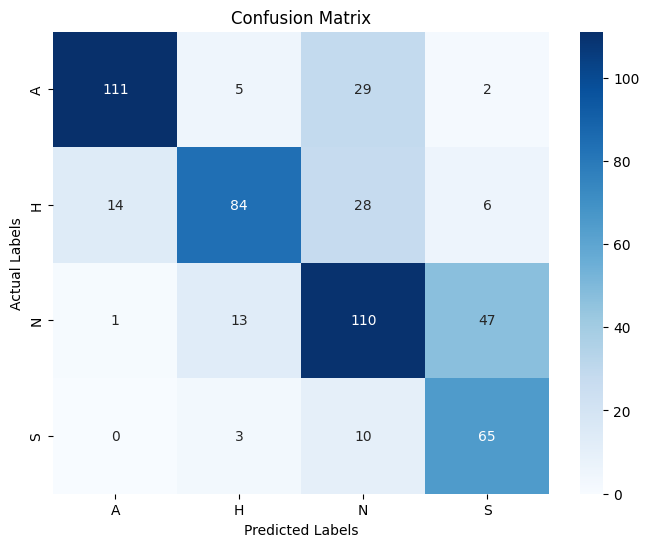

Confusion Matrix:
     A   H    N   S
A  111   5   29   2
H   14  84   28   6
N    1  13  110  47
S    0   3   10  65

Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.76      0.81       147
           H       0.80      0.64      0.71       132
           N       0.62      0.64      0.63       171
           S       0.54      0.83      0.66        78

    accuracy                           0.70       528
   macro avg       0.71      0.72      0.70       528
weighted avg       0.73      0.70      0.71       528



In [16]:
if not SKIP_TESTING_AFTER_TRAINING:
    model = model.to('cpu')
    test_model(test_dataframe, model)

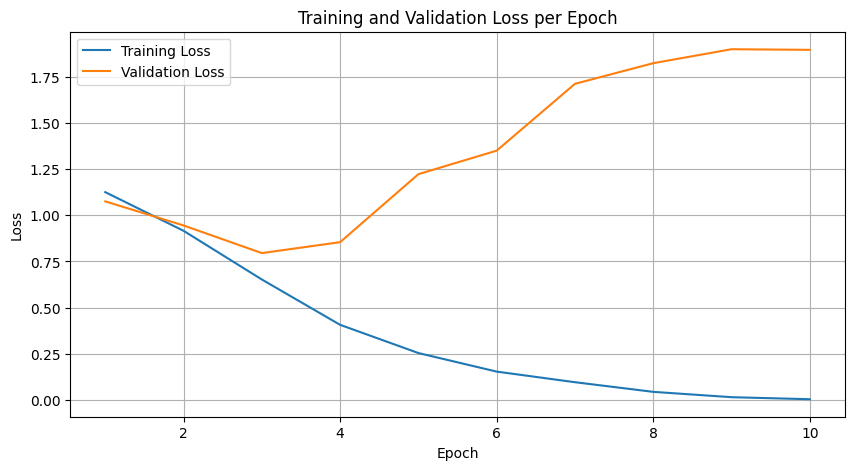

In [17]:
if PLOT_TRAINING_GRAPHS and not LOAD_PREVIOUSLY_TRAINED_MODEL:
    
    train_losses = {}
    val_losses = {}
    epochs = set()

    for log in trainer.state.log_history:
        if 'epoch' in log:
            epoch = log['epoch']
            epochs.add(epoch)
            if 'loss' in log:
                train_losses[epoch] = log['loss']
            if 'eval_loss' in log:
                val_losses[epoch] = log['eval_loss']

    # Sort the epochs and extract losses
    epochs = sorted(epochs)
    train_loss_list = [train_losses.get(epoch) for epoch in epochs]
    val_loss_list = [val_losses.get(epoch) for epoch in epochs]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss_list, label='Training Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

## Run Multi Model Prediction
**If model performance is good enough, then continue with the secondary model**

In [18]:
def multi_predict(model, test_dataframe):

    results = []
    total = test_dataframe.shape[0]
    count = 1

    # Iterate over each audio file in the test folder
    for index, row in test_dataframe.iterrows():

        # Display progress
        print(f'File {count} of {total}', end='\r')
        count += 1

        # Load audio file
        filename = row['filename'] + '.wav'
        audio_file = os.path.join(AUDIO_DIRECTORY, filename)
        audio, sample_rate = librosa.load(audio_file, sr = 16000)

        inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt")
        
        # Tokenize the input audio for speech-to-text model
        input_values = S2T_processor(audio, return_tensors="pt", sampling_rate=16000, padding="longest").input_values

        # Extract features from the audio
        inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt")
        
        # Tokenize the input audio for speech-to-text model
        input_values = S2T_processor(audio, return_tensors="pt", sampling_rate=16000, padding="longest").input_values  # Batch size 1
        #input_values = input_values.to(device) 

        # Get the logits from the model
        with torch.no_grad():
            logits = model(**inputs).logits
            S2T_logits = S2T_Model(input_values).logits
            
            # Retrieve logits and decode the predicted ids for transcription
            predicted_ids = torch.argmax(S2T_logits, dim=-1)
            transcription = S2T_processor.batch_decode(predicted_ids)[0]

        # Predict the class with the highest logit value
        predicted_class_id = torch.argmax(logits).item()
        
        # Apply softmax to logits to get the probabilities
        probabilities = torch.softmax(logits, dim=-1)
        
        # Run sentiment analysis on the transcription
        sentiment = sentiment_task(transcription)
        sentiment_label = sentiment[0]['label']
        sentiment_score = sentiment[0]['score']

        # Extract the filename without the extension
        filename = os.path.splitext(os.path.basename(audio_file))[0]

        # Append the result to the list
        results.append([filename, predicted_class_id, probabilities[0][0].item(), probabilities[0][1].item(), 
                        probabilities[0][2].item(), probabilities[0][3].item(), sentiment_label, sentiment_score])

    # Write the results to a CSV file
    global MULTI_PREDICTION_CSV_FILEPATH
    MULTI_PREDICTION_CSV_FILEPATH = PREDICTION_OUTPUT_FOLDER + "/" + OUTPUT_MODEL_NAME + "-raw.csv"
    os.makedirs(PREDICTION_OUTPUT_FOLDER, exist_ok=True)
    
    with open(MULTI_PREDICTION_CSV_FILEPATH , 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ID', 'Predict', '0_Score','1_Score', '2_Score', '3_Score', 'Sentiment', 'Sentiment_Score'])
        writer.writerows(results)

    print(f"Multi model predictions saved to {MULTI_PREDICTION_CSV_FILEPATH}")

In [19]:
if not (LOAD_MULTI_PREDICTION_DIRECTLY_FROM_CSV and not ONLY_RUN_TRAINING_LOOP) or FORCE_MULTI_PREDICT:
    model = model.to('cpu')
    multi_predict(model, test_dataframe)

Multi model predictions saved to ./Predictions/integrated-notebook-finaltest-default-model-raw.csv


In [20]:
model = model.to('cpu')
multi_predict(model, test_dataframe)

Multi model predictions saved to ./Predictions/integrated-notebook-finaltest-default-model-raw.csv


## Mutli Model Prediction Merging Algorithm

#### Define Helper Functions

In [21]:
# Calculate entropy function
def calculate_entropy(w, x, y ,z):
    probabilities = torch.tensor([w, x, y, z])
    entropy = -torch.sum(probabilities* torch.log(probabilities + 1e-10)) # small value to avoid log(0)
    return entropy.item()

In [22]:
# Remaps the 3 sentiment to the 4 emotions.
def remap_sentiment(mode, dataframe_row, sentiment_threshold, flip):
    
    sentiment = dataframe_row['Sentiment']
    score = dataframe_row['Sentiment_Score']
    
    if sentiment == 'neutral':
        return 2
    elif sentiment == 'positive':
        return 1
    else: # Else sentiment is negative
        
        if mode == 'simple': 
            # There can be two possible mapping for negative sentiment.
            # Either to sad or angry.
            if score <= sentiment_threshold:
                return 0 if not flip else 3
            else:
                return 3 if not flip else 0
        
        # If sentiment is negative, refer to orignal model to decidce how to map
        # negative sentiment to both angry or sad
        else:
            angry_score = dataframe_row['0_Score']
            sad_score = dataframe_row['3_Score']
            if angry_score >= sad_score:
                return 0
            else:
                return 3

In [23]:
# Function to perform accuracy evaluation
def calculate_accuracy(dataframe, mode, show, save_file):
    
    # Define a remapping dictionary
    remap_dict = {
        0: 'A',
        1: 'H',
        2: 'N',
        3: 'S'
    }
    
    if mode: # Apply the remap to the original model's predictions
        
        # Apply the remap function to the 'Predict' column
        dataframe['Predict'] = dataframe['Predict'].map(remap_dict)

        # Merge DataFrames on 'filename'
        df_merged = pd.merge(reference[['filename', 'label']],dataframe[['ID', 'Predict']],left_on='filename',right_on='ID')

        # Extract true labels and predictions
        y_true = df_merged['label']
        y_pred = df_merged['Predict']
        
    else: # Apply the remap to the modified final predictions
        
        if save_file and FORMAT_CSV_FOR_KAGGLE:
            kaggle_dataframe = pd.DataFrame()
            kaggle_dataframe['ID'] = dataframe['ID']
            kaggle_dataframe['Predict'] = dataframe['Final']
        
        # Apply the remap function to the 'Predict' column
        dataframe['Final'] = dataframe['Final'].map(remap_dict)

        # Merge DataFrames on 'filename'
        df_merged = pd.merge(reference[['filename', 'label']], dataframe[['ID', 'Final']],left_on='filename',right_on='ID')

        # Extract true labels and predictions
        y_true = df_merged['label']
        y_pred = df_merged['Final']
        
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame for the confusion matrix
    labels = sorted(y_true.unique())
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    if show:
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.title('Confusion Matrix')
        plt.show()

    # Compute and print UA score
    macro_recall = recall_score(y_true, y_pred, average='macro')
    if show:
        print(f"test UA: {macro_recall}")
    
        # Print the confusion matrix
        #print("Confusion Matrix:")
        #print(cm_df)

    if show:
        # Compute and print classification report
        report = classification_report(y_true, y_pred, labels=labels)
        print("\nClassification Report:")
        print(report)
        
        
    if save_file:
        
        os.makedirs(PREDICTION_OUTPUT_FOLDER, exist_ok=True)
        
        if FORMAT_CSV_FOR_KAGGLE:          
            csv_name = PREDICTION_OUTPUT_FOLDER + "/label.csv"
            kaggle_dataframe.to_csv(csv_name, index=False)
            print(f"Predictions formatted and saved for kaggle submission at {csv_name}")
            
        else:        
            csv_name = PREDICTION_OUTPUT_FOLDER + "/" + OUTPUT_MODEL_NAME + "-detailed.csv"
            df_merge_all = pd.merge(reference, dataframe ,left_on='filename',right_on='ID')
            reorganize_column = df_merge_all['label'] # Shift correct labels for easier viewing later
            df_merge_all = df_merge_all.drop(columns=['ID', 'label', 'duration', 'fold', 'condition'])
            df_merge_all['label'] = reorganize_column
            df_merge_all.to_csv(csv_name, index=False)
            print(f"Predictions saved for analysis at {csv_name}")
            
    return macro_recall

In [24]:
def show_best_results(use_entrophy, best_sentiment_threshold, best_entrophy_or_argmax_threshold, 
                      prediction_strategy, sentiment_strategy, sad_angry_flip, final_run):
    
    # Read back from disk a fresh state of dataframe
    df = pd.read_csv(MULTI_PREDICTION_CSV_FILEPATH)

    # Creates a column for the final prediction
    df['Final'] = None
    
    # Iterate over each row in dataframe
    for index, row in df.iterrows():

        if use_entrophy: # Calculate the entrophy in each row                           
            apply_entrophy(df, index, row, best_entrophy_or_argmax_threshold, best_sentiment_threshold, sad_angry_flip, 
                           prediction_strategy, sentiment_strategy)        

        else: # Use argmax for threshold                 
            apply_argmax(df, index, row, best_entrophy_or_argmax_threshold, best_sentiment_threshold, sad_angry_flip,
                         prediction_strategy, sentiment_strategy)
            
    if final_run:
        df_save = df.copy()
    
    print("\n--------- Original Model ---------")
    calculate_accuracy(df, True, True, False)
    print("\n---------  Multi Model ---------")
    calculate_accuracy(df, False, True, False)
    
    if final_run and SAVE_FINAL_PREDICTION_CSV:
        calculate_accuracy(df_save, False, False, True)
        
    if not final_run:
        return [use_entrophy, best_sentiment_threshold, best_entrophy_or_argmax_threshold, prediction_strategy, sentiment_strategy, sad_angry_flip]

#### Main Functions

In [25]:
def apply_entrophy(df, index, row, entrophy_threshold, sentiment_threshold, sad_angry_flip, 
                   prediction_strategy = 'default', sentiment_strategy = 'simple'):
    
    entropy = calculate_entropy(row['0_Score'], row['1_Score'], row['2_Score'], row['3_Score'])
    
    # Threshold reached, apply additional logic to output
    if entropy >= entrophy_threshold:
        
        # Default mode. 2nd model overrides original model
        if prediction_strategy == 'default':
            df.at[index, 'Final'] = remap_sentiment(sentiment_strategy, row, sentiment_threshold, sad_angry_flip)
            
        # original model seems to be good at detecting angry and happy. So even if threshold reached, we ignore
        elif prediction_strategy == 'ignore':
            df.at[index, 'Final'] = row['Predict']
            
        # If both models predict the same emotion, ignore any thresholds and assume it is correct 
        elif prediction_strategy == 'ignore-when-match':
            
            # Obtain remapped sentiment
            sentiment = remap_sentiment(sentiment_strategy, row, sentiment_threshold, sad_angry_flip)
            
            # If both models agree on the same emotion
            if sentiment == row['Predict']:
                
                # Copy over with no change
                df.at[index, 'Final'] = row['Predict']
                
            else: # Prefer model 2 over original model
                df.at[index, 'Final'] = sentiment
            
    
    # Threshold not reached, copy original prediction to output column
    else:
        df.at[index, 'Final'] = row['Predict']

In [26]:
def apply_argmax(df, index, row, argmax_threshold, sentiment_threshold, sad_angry_flip,
                 prediction_strategy = 'default', sentiment_strategy = 'simple'):
    
    argmax_value = max(row['0_Score'], row['1_Score'], row['2_Score'], row['3_Score'])
    
    # Threshold reached, apply additional logic to output
    if argmax_value <= argmax_threshold:
        
        # Default mode. 2nd model overrides original model
        if prediction_strategy == 'default':
            df.at[index, 'Final'] = remap_sentiment(sentiment_strategy, row, sentiment_threshold, sad_angry_flip)
            
        # original model seems to be good at detecting angry and happy. So even if threshold reached, we ignore
        elif prediction_strategy == 'ignore':
            df.at[index, 'Final'] = row['Predict']
            
        # If both models predict the same emotion, ignore any thresholds and assume it is correct 
        elif prediction_strategy == 'ignore-when-match':
            
            # Obtain remapped sentiment
            sentiment = remap_sentiment(sentiment_strategy, row, sentiment_threshold, sad_angry_flip)
            
            # If both models agree on the same emotion
            if sentiment == row['Predict']:
                
                # Copy over with no change
                df.at[index, 'Final'] = row['Predict']
                
            else: # Prefer model 2 over original model
                df.at[index, 'Final'] = sentiment
            
    
    # Threshold not reached, copy original prediction to output column
    else:
        df.at[index, 'Final'] = row['Predict']

In [27]:
def MergePrediction(use_entrophy, sentiment_threshold_range, entrophy_threshold_range, prediction_strategy, sentiment_strategy, sad_angry_flip):
    
     # keeps track of progress
    iter_counter = 1
    
    # Hold best params
    best_difference = 0
    best_sentiment_threshold = 0
    best_entrophy_or_argmax_threshold = 0
    best_flip = False
    
    # Use user selected threshold metric
    if use_entrophy:
        threshold_type = entrophy_threshold_range
        total_iter = len(entrophy_threshold_range) * len(sentiment_threshold_range)
    else:
        threshold_type = argmax_threshold_range
        total_iter = len(argmax_threshold_range) * len(sentiment_threshold_range)
    
    for entro_or_argmax in threshold_type:
        for senti in sentiment_threshold_range:
            
            print(f"Iteration {iter_counter} of {total_iter}", end='\r')
            iter_counter += 1

            entrophy_or_argmax_threshold = round(entro_or_argmax,3)
            sentiment_threshold = round(senti,3)
        
            # Read back from disk a fresh state of the dataframe
            df = pd.read_csv(MULTI_PREDICTION_CSV_FILEPATH)
            
            # Creates a column for the final output prediction
            df['Final'] = None
       
            # Iterate over each row in dataframe
            for index, row in df.iterrows():
                
                if use_entrophy: # Calculate the entrophy in each row                           
                    apply_entrophy(df, index, row, entrophy_or_argmax_threshold, sentiment_threshold, sad_angry_flip, 
                                   prediction_strategy, sentiment_strategy)        
                    
                else: # Use argmax for threshold                 
                    apply_argmax(df, index, row, entrophy_or_argmax_threshold, sentiment_threshold, sad_angry_flip,
                                  prediction_strategy, sentiment_strategy)
                    
                 
            # Start before and after comparison
            original_accuracy = calculate_accuracy(df, True, False, False)           
            new_accuracy = calculate_accuracy(df, False, False, False)                
            difference = new_accuracy - original_accuracy
      
            # Check if current run has the best results
            if difference > best_difference:
                best_difference = difference
                best_sentiment_threshold = sentiment_threshold
                best_entrophy_or_argmax_threshold = entrophy_or_argmax_threshold
                best_flip = sad_angry_flip

    #Print out best params at the end
    if best_difference != 0:
        
        print("----- Run Completed Report -----")
        if use_entrophy:        
            print("Metric Used: Entrophy")
            print(f"Prediction Strategy Used: {prediction_strategy}")
            print(f"Sentiment Strategy Used: {sentiment_strategy}")
            print(f"Best entrophy_threshold is {best_entrophy_or_argmax_threshold}")
        else:
            print("Metric Used: Argmax")
            print(f"Strategy Used: {prediction_strategy}")
            print(f"Sentiment Strategy Used: {sentiment_strategy}")
            print(f"Best best_argmax_threshold is {best_entrophy_or_argmax_threshold}")
        print(f"Best sentiment_threshold is {best_sentiment_threshold}")
        print(f"And sad_angry_flip set to: {best_flip}")
        print(f"with an improvement of {best_difference:.4g}")
        
        best_params_list = show_best_results(use_entrophy, best_sentiment_threshold, best_entrophy_or_argmax_threshold,
                                             prediction_strategy, sentiment_strategy, best_flip, False)
        best_params_list.append("{:.4g}".format(best_difference))
        
    else:
        print(f"\nWent through {iter_counter-1} iterations")
        print("Multi Model did not improve overall results\n")
        
        best_params_list = [None, None, None, prediction_strategy, False, "0"]  # Default placeholders
 
    return best_params_list

#### Main Code

----- Run Completed Report -----
Metric Used: Entrophy
Prediction Strategy Used: default
Sentiment Strategy Used: default
Best entrophy_threshold is 1.06
Best sentiment_threshold is 0.3
And sad_angry_flip set to: True
with an improvement of 0.01873

--------- Original Model ---------


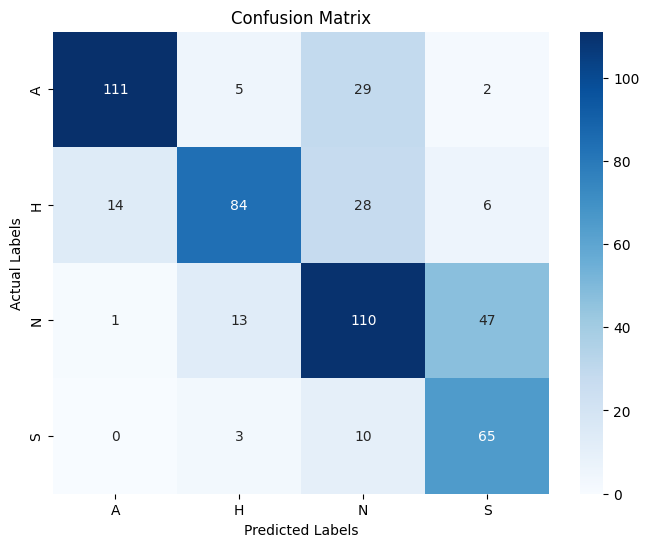

test UA: 0.7170184660786165

Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.76      0.81       147
           H       0.80      0.64      0.71       132
           N       0.62      0.64      0.63       171
           S       0.54      0.83      0.66        78

    accuracy                           0.70       528
   macro avg       0.71      0.72      0.70       528
weighted avg       0.73      0.70      0.71       528


---------  Multi Model ---------


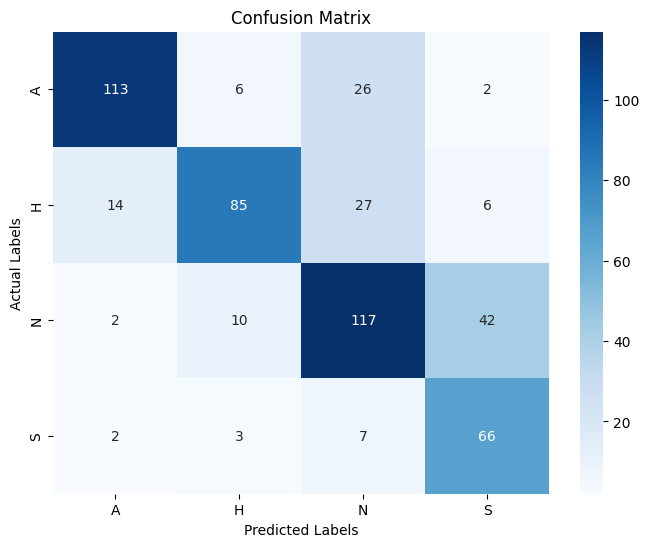

test UA: 0.7357528123505567

Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.77      0.81       147
           H       0.82      0.64      0.72       132
           N       0.66      0.68      0.67       171
           S       0.57      0.85      0.68        78

    accuracy                           0.72       528
   macro avg       0.73      0.74      0.72       528
weighted avg       0.74      0.72      0.72       528

-------------------------------------- Overall Run Report --------------------------------------
Best overall improvement of: +0.01873
Prediction Strategy: 'default' 
Sentiment Strategy: 'default' 
Metric: 'Entrophy' with threshold of 1.06
Sentiment threshold of 0.3
Flip: True

------------------------------------- Overall Best Results -------------------------------------

--------- Original Model ---------


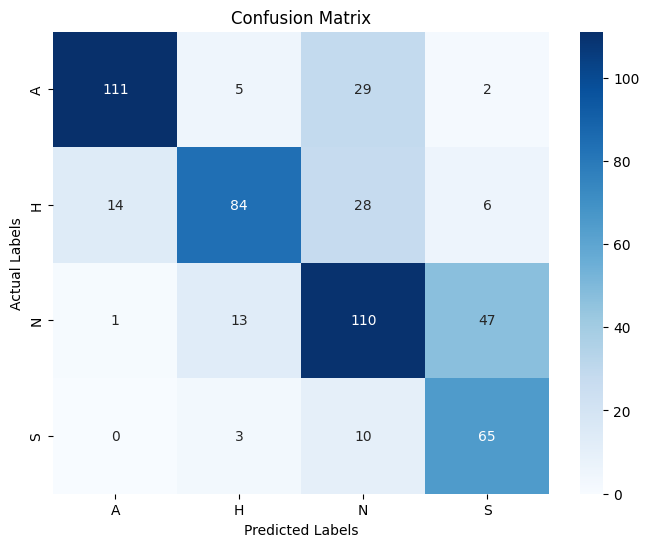

test UA: 0.7170184660786165

Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.76      0.81       147
           H       0.80      0.64      0.71       132
           N       0.62      0.64      0.63       171
           S       0.54      0.83      0.66        78

    accuracy                           0.70       528
   macro avg       0.71      0.72      0.70       528
weighted avg       0.73      0.70      0.71       528


---------  Multi Model ---------


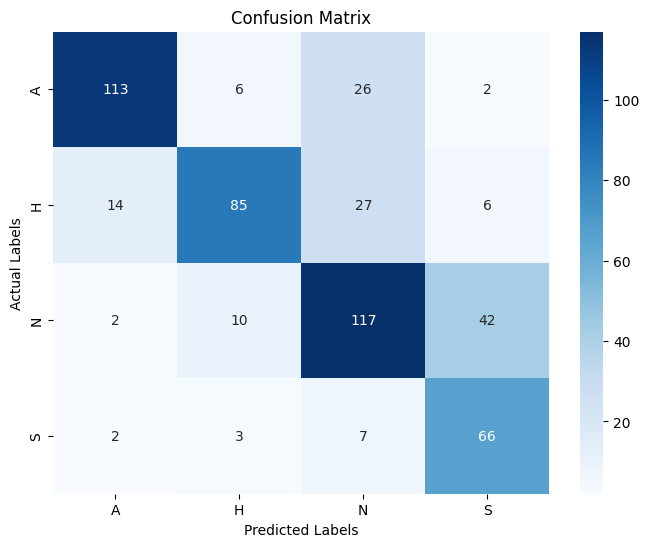

test UA: 0.7357528123505567

Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.77      0.81       147
           H       0.82      0.64      0.72       132
           N       0.66      0.68      0.67       171
           S       0.57      0.85      0.68        78

    accuracy                           0.72       528
   macro avg       0.73      0.74      0.72       528
weighted avg       0.74      0.72      0.72       528

Predictions formatted and saved for kaggle submission at ./Predictions/label.csv


In [28]:
if not (ONLY_RUN_TRAINING_LOOP and RUN_PARAMETER_SEARCH) or FORCE_PARAMETER_SEARCH:

    overall_best_metric = ''
    overall_best_prediction_strategy = ''
    overall_best_sentiment_strategy = ''
    overall_best_metric_threshold = 0.0
    overall_best_sentiment_threshold = 0.0
    overall_best_improvement = 0.0
    overall_best_flip = False
    
    sentiment_threshold_range = np.arange(sentiment_start , sentiment_stop + sentiment_step , sentiment_step)
    entrophy_threshold_range = np.arange(enthropy_start , enthropy_stop + enthropy_step , enthropy_step)
    argmax_threshold_range = np.arange(argmax_start , argmax_stop + argmax_step , argmax_step)
    reference = pd.read_csv(TSV, sep='\t')

    list_of_results = []

    for use_entrophy in [True]:
        for sad_angry_flip in [True]:
            for prediction_strategy in ['default']:
                for sentiment_strategy in ['default']:

                    # Run with the current parameter combination
                    result = MergePrediction(use_entrophy, sentiment_threshold_range, entrophy_threshold_range, 
                                             prediction_strategy, sentiment_strategy, sad_angry_flip)
                    list_of_results.append(result)

                    current_metric = result[0]
                    current_improvement = float(result[-1])

                    # Check if the current result is better than the overall best
                    if current_improvement > overall_best_improvement:

                        # Update the overall best values
                        overall_best_metric = current_metric
                        overall_best_prediction_strategy = prediction_strategy
                        overall_best_sentiment_strategy = sentiment_strategy
                        overall_best_metric_threshold = result[2]
                        overall_best_sentiment_threshold = result[1]
                        overall_best_improvement = current_improvement
                        overall_best_flip = result[-2]

    # Print the best result
    if overall_best_metric:
        text = 'Entrophy'
        use_entro = True
    else:
        text = 'Argmax'
        use_entro = False
    print("-------------------------------------- Overall Run Report --------------------------------------")
    print(f"Best overall improvement of: +{overall_best_improvement}")
    print(f"Prediction Strategy: '{overall_best_prediction_strategy}' ")
    print(f"Sentiment Strategy: '{overall_best_sentiment_strategy}' ")
    print(f"Metric: '{text}' with threshold of {overall_best_metric_threshold}")
    print(f"Sentiment threshold of {overall_best_sentiment_threshold}")
    print(f"Flip: {overall_best_flip}")
    print("\n------------------------------------- Overall Best Results -------------------------------------")
    show_best_results(use_entro, overall_best_sentiment_threshold, overall_best_metric_threshold, overall_best_prediction_strategy, overall_best_sentiment_strategy, overall_best_flip, True)